In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'EMB'  # emerging markets
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_emb.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed
Generating derived columns...
(4247, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2007-12-19,101.040001,101.220001,101.040001,101.220001,44.972717,3.806056,1.001781,1.000396,1.000889
2007-12-20,101.309998,101.309998,101.260002,101.260002,44.990505,3.806451,0.999507,0.998913,1.002370
2007-12-21,101.500000,101.540001,101.029999,101.150002,44.941612,3.805364,0.996552,1.001779,1.001780
2007-12-24,101.330002,101.330002,101.330002,101.330002,45.021553,3.807141,1.000000,1.000790,0.999605
2007-12-26,101.290001,101.410004,101.290001,101.410004,45.057140,3.807931,1.001185,0.999219,0.998422
2007-12-27,101.250000,101.250000,101.099998,101.169998,45.021973,3.807151,0.999210,1.000396,1.000297
2007-12-28,101.199997,101.209999,101.169998,101.209999,45.039791,3.807546,1.000099,1.001383,1.001581
2007-12-31,101.370003,101.400002,101.349998,101.349998,45.102070,3.808928,0.999803,1.001382,0.998027
2008-01-02,101.150002,101.529999,101.150002,101.489998,45.164379,3.810309,1.003361,1.001773,1.002759


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2007-12-19    101.220001
2007-12-20    101.309998
2007-12-21    101.540001
2007-12-26    101.410004
2007-12-27    101.250000
                 ...    
2024-10-28     91.459999
2024-10-29     91.580002
2024-10-30     91.889999
2024-10-31     91.440002
2024-11-01     90.889999
Name: high, Length: 4242, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2010-01-04')  # first day of legit open/close values
SIM_START

Timestamp('2010-01-04 00:00:00')

In [7]:
len(df.index >= SIM_START)

4247

In [8]:
df[df.index >= SIM_START]

,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2010-01-04,101.739998,101.930000,101.330002,101.930000,51.004070,3.931905,1.001868,1.006082,1.002747
2010-01-05,102.209999,102.580002,102.070000,102.550003,51.314289,3.937969,1.003327,1.001365,1.000488
2010-01-06,102.599998,102.750000,102.230003,102.690002,51.384354,3.939334,1.000877,0.994839,0.996981
2010-01-07,102.379997,102.510002,102.099998,102.160004,51.119148,3.934159,0.997851,1.001175,1.001175
2010-01-08,102.279999,102.489998,102.180000,102.279999,51.179203,3.935333,1.000000,1.007626,1.007235
...,...,...,...,...,...,...,...,...,...
2024-10-28,91.360001,91.459999,91.180000,91.349998,90.926003,4.510046,0.999891,1.002299,0.999453
2024-10-29,91.300003,91.580002,91.150002,91.559998,91.135033,4.512342,1.002848,0.998908,1.000328
2024-10-30,91.589996,91.889999,91.410004,91.459999,91.035492,4.511249,0.998581,0.994096,0.998797


In [9]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']), #'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [10]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [11]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

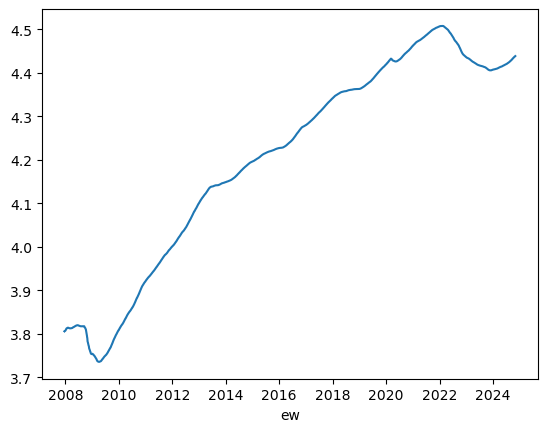

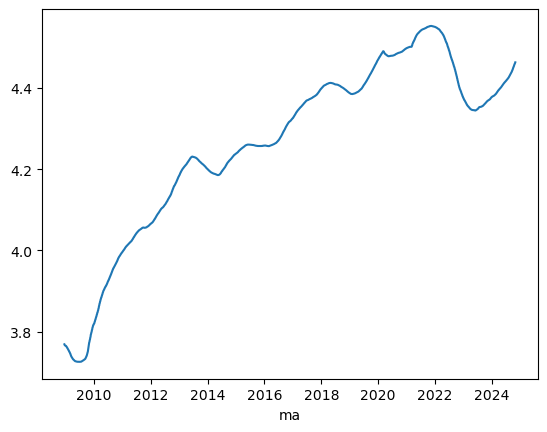

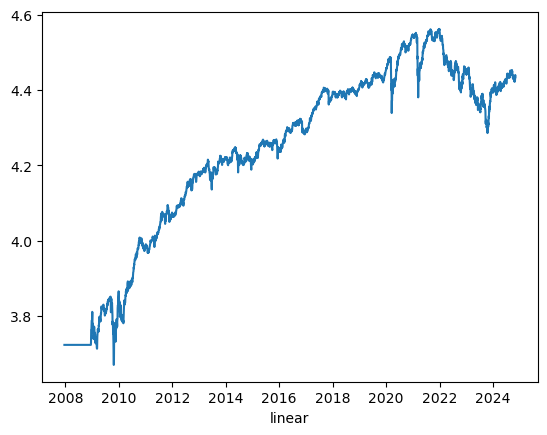

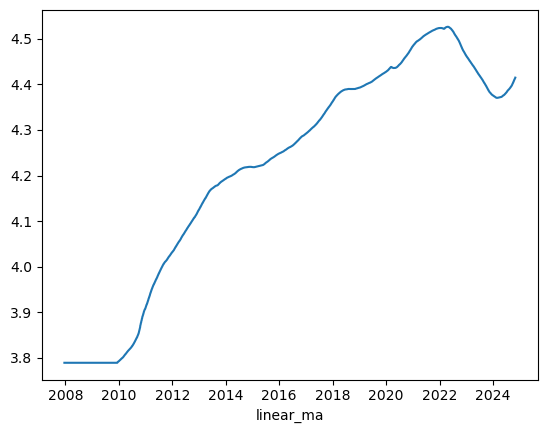

In [12]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [13]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [14]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [15]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [16]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [17]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [18]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params #= None, None

(None, None)

Do nothing res: 1.7673099203906297
Round 1: 1.5388887951813943
New best: 1.5388887951813943
{'time_param': 130, 'method': 'ma', 't': 0.04364723002299975, 'k': 0.1287681731364386, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


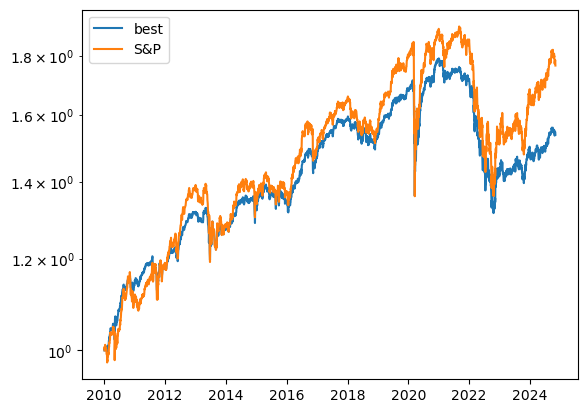

Round 2: 1.596109394461465
New best: 1.596109394461465
{'time_param': 100, 'method': 'ma', 't': 0.5808857590285622, 'k': 0.12228438960030977, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


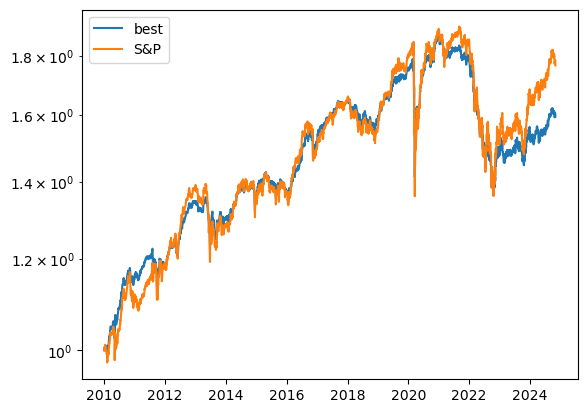

Round 3: 1.631610651511127
New best: 1.631610651511127
{'time_param': 105, 'method': 'ew', 't': 0.5083800432870335, 'k': 3.3038208033618277, 'as_q': False, 'transform_f': 'bounded_curve'}


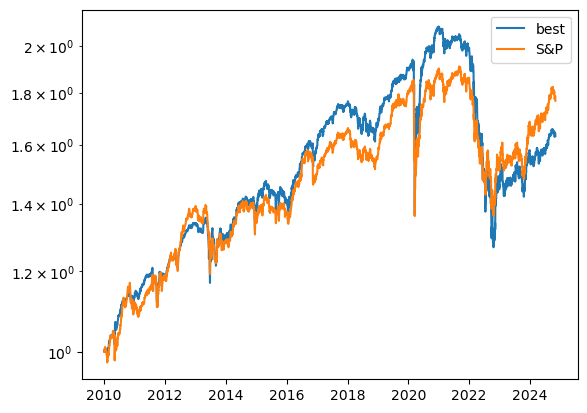

Round 4: 2.4124791634035856
New best: 2.4124791634035856
{'time_param': 60, 'method': 'linear', 't': 0.7705554615534135, 'k': 6.901640508523085, 'as_q': True, 'transform_f': 'bounded_curve'}


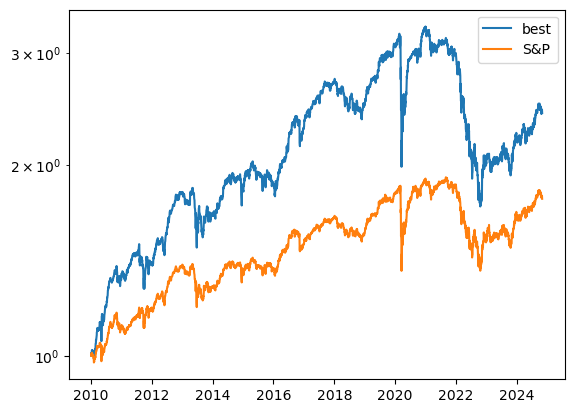

Round 5: 1.5761834772819057
Round 6: 1.0176554886090827
Round 7: 1.9983551207880716
Round 8: 1.1080473538390894
Round 9: 1.3398319194884667
Round 10: 1.6955349642150828
Round 11: 1.1480103640644836
Round 12: 1.8228268116196291
Round 13: 1.0213098005106618
Round 14: 1.6115984136596944
Round 15: 1.5332835692143552
Round 16: 1.2988356938189727
Round 17: 2.529766223554311
New best: 2.529766223554311
{'time_param': 189, 'method': 'ma', 't': 0.8710746295546795, 'k': 7.158372048425621, 'as_q': True, 'transform_f': 'bounded_curve'}


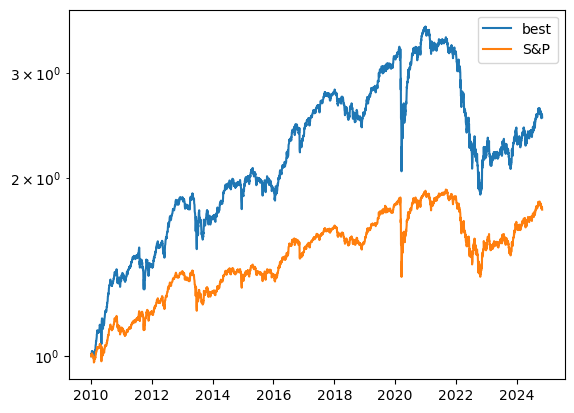

Round 18: 1.8446122158619964
Round 19: 1.2165419641935353
Round 20: 1.1155433774468853
Round 21: 2.568172942788685
New best: 2.568172942788685
{'time_param': 123, 'method': 'linear', 't': 0.7202051882564754, 'k': 8.959373373173356, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


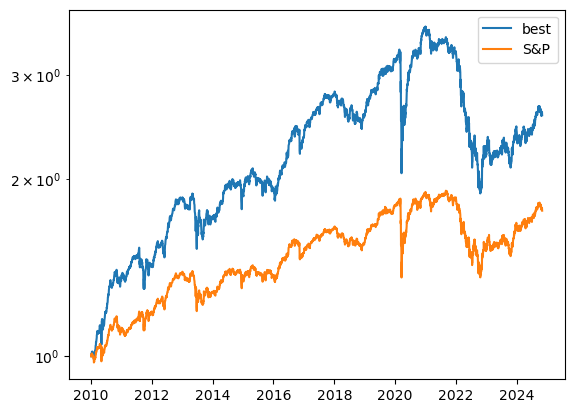

Round 22: 1.1187108366416174
Round 23: 1.0768308654190653
Round 24: 1.2230122774580816
Round 25: 1.1088461859352727
Round 26: 1.6132981818022074
Round 27: 2.037158764141682
Round 28: 1.0796842748505875
Round 29: 1.424771546440272
Round 30: 1.0590621554198318
Round 31: 1.2437872041339282
Round 32: 1.7991924643501411
Round 33: 1.5858280476235518
Round 34: 1.1947412167330267
Round 35: 1.0329735241983493
Round 36: 1.549077375667996
Round 37: 1.3378854218500664
Round 38: 1.0938394907947349
Round 39: 1.0839086695621098
Round 40: 1.0555471533902812
Round 41: 1.6243659402896569
Round 42: 1.324565267807686
Round 43: 1.5639927098112287
Round 44: 2.548066961657238
Round 45: 1.1453368225948877
Round 46: 1.4110071645914473
Round 47: 2.5523060615663984
Round 48: 1.111948946682271
Round 49: 1.707487547594626
Round 50: 2.4890792444971255
Round 51: 1.4142534960780808
Round 52: 1.5072154536589846
Round 53: 1.7943123303483528
Round 54: 1.6512494439243912
Round 55: 1.0004881755443051
Round 56: 2.559308572

In [19]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 1.7673099203906297
Round 1: 2.55834137110858
Round 2: 2.55834137110858
Round 3: 1.9147824048271547
Round 4: 1.1481095137730282
Round 5: 2.5566012962882594
Round 6: 1.0751890086977212
Round 7: 1.1062872720167296
Round 8: 2.55834137110858
Round 9: 2.6022345948256644
New best: 2.6022345948256644
{'time_param': 129, 'method': 'linear', 't': 0.7591364253876374, 'k': 9.332047145143964, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


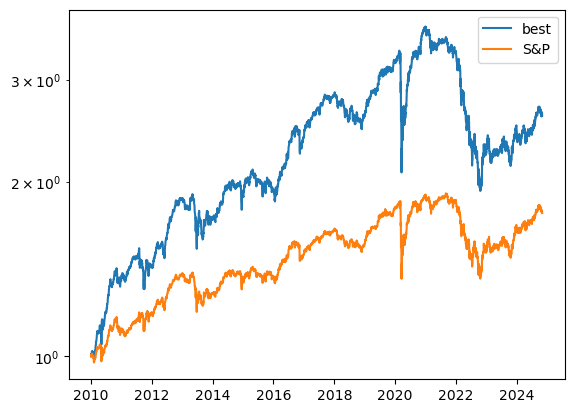

Round 10: 2.558341371993954
Round 11: 2.5580704460339216
Round 12: 1.0916715907180368
Round 13: 0.9384733032944484
Round 14: 1.0534046080926165
Round 15: 1.0000113466024274
Round 16: 2.365889255105265
Round 17: 2.5548786336118914
Round 18: 2.55834137110858
Round 19: 1.0909000666395738
Round 20: 0.9687993085198675
Round 21: 1.6430229614038523
Round 22: 1.0109593114388784
Round 23: 1.010617505357568
Round 24: 2.5584631014024355
Round 25: 1.106063738512842

Factor: 1.03125
Do nothing res: 1.7673099203906297
Round 1: 0.9461184151386459
Round 2: 1.4301350645666269
Round 3: 2.55834137110858
Round 4: 2.55834137110858
Round 5: 2.55834137110858
Round 6: 2.5583353492385066
Round 7: 1.0670196943027341
Round 8: 2.55834137110858
Round 9: 2.55834137110858
Round 10: 2.5583413711055583
Round 11: 2.5583413958705576
Round 12: 2.5730614437723514
Round 13: 2.55834137110858
Round 14: 2.0472641628358197
Round 15: 2.5640977706284427
Round 16: 1.0374804678882263
Round 17: 2.495016322356758
Round 18: 1.0340283

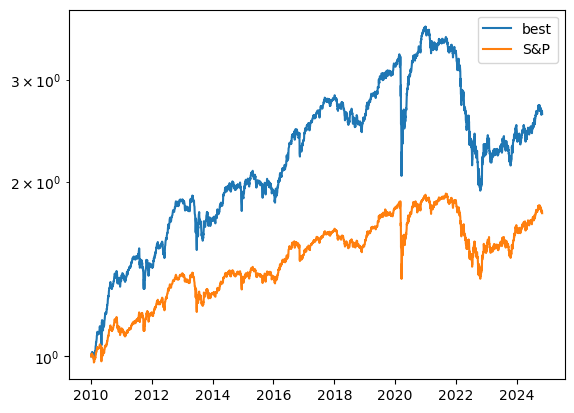

Round 8: 0.9978985603599743
Round 9: 2.6594073248673356
New best: 2.6594073248673356
{'time_param': 128, 'method': 'linear', 't': 0.7226690303634753, 'k': 9.173624596709974, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


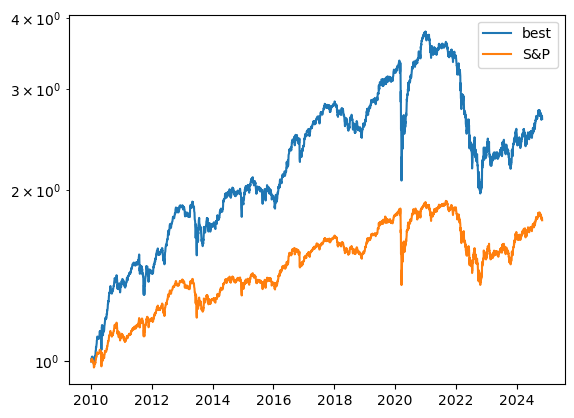

Round 10: 2.5586633511230668
Round 11: 1.620704184899644
Round 12: 1.0000000018687536
Round 13: 2.5583413718309775
Round 14: 2.598921599158625
Round 15: 2.5587629454685996
Round 16: 1.418118059308828
Round 17: 2.590708644381526
Round 18: 2.6134310907559613
Round 19: 1.0738965335861275
Round 20: 2.63593383537484
Round 21: 2.653210515274556
Round 22: 1.004672302927698
Round 23: 1.5506911748573253
Round 24: 0.9497677434301837
Round 25: 1.5018985853321547

Factor: 1.0078125
Do nothing res: 1.7673099203906297
Round 1: 2.2135414831458973
Round 2: 1.5166288482922607
Round 3: 2.5583414014708565
Round 4: 0.9626157426910219
Round 5: 2.577798781284286
Round 6: 1.1087067109816535
Round 7: 2.6438153671203937
Round 8: 2.6594691536673967
New best: 2.6594691536673967
{'time_param': 128, 'method': 'linear', 't': 0.7258216679560952, 'k': 9.208825565525784, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


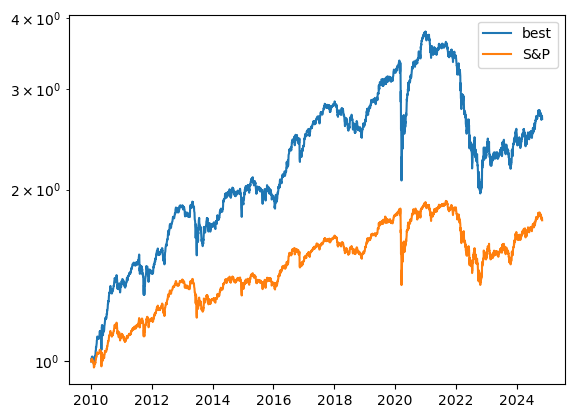

Round 9: 2.5583415328396653
Round 10: 2.5607898774294156
Round 11: 2.6286060735334944
Round 12: 0.9240095169631166
Round 13: 1.087467129745417
Round 14: 1.1307262816258412
Round 15: 2.55834137110858
Round 16: 0.9210835701085729
Round 17: 0.9360987651619235
Round 18: 1.000000223807531
Round 19: 1.0000000017639277
Round 20: 2.5584145502532216
Round 21: 1.0720969035329107
Round 22: 2.55834137110858
Round 23: 2.55834137110858
Round 24: 2.558759243200368
Round 25: 1.9115311431636304



In [20]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [21]:
# Force set:
#best_out = 1.785863355710255
#params_out = {'time_param': 160, 'method': 'linear', 't': 0.8604701020371026, 'k': 6.0009414899488185, 'as_q': True, 'transform_f': 'bounded_sigmoid'}

In [22]:
final_out = simulate(df, params_out)

In [23]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9995669232848786

In [24]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.5743249470903513

In [25]:
params_out

{'time_param': 128,
 'method': 'linear',
 't': 0.7258216679560952,
 'k': 9.208825565525784,
 'as_q': False,
 'transform_f': 'bounded_sigmoid'}

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


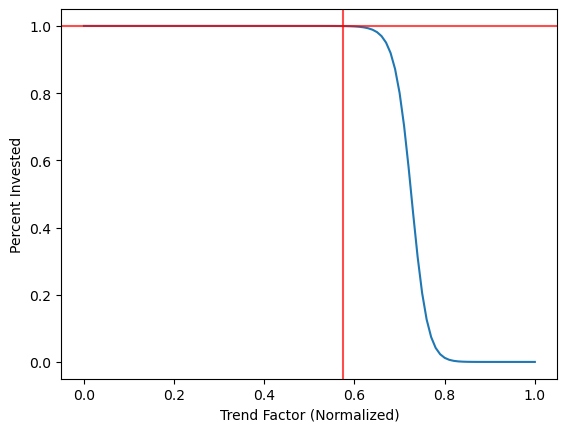

In [26]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

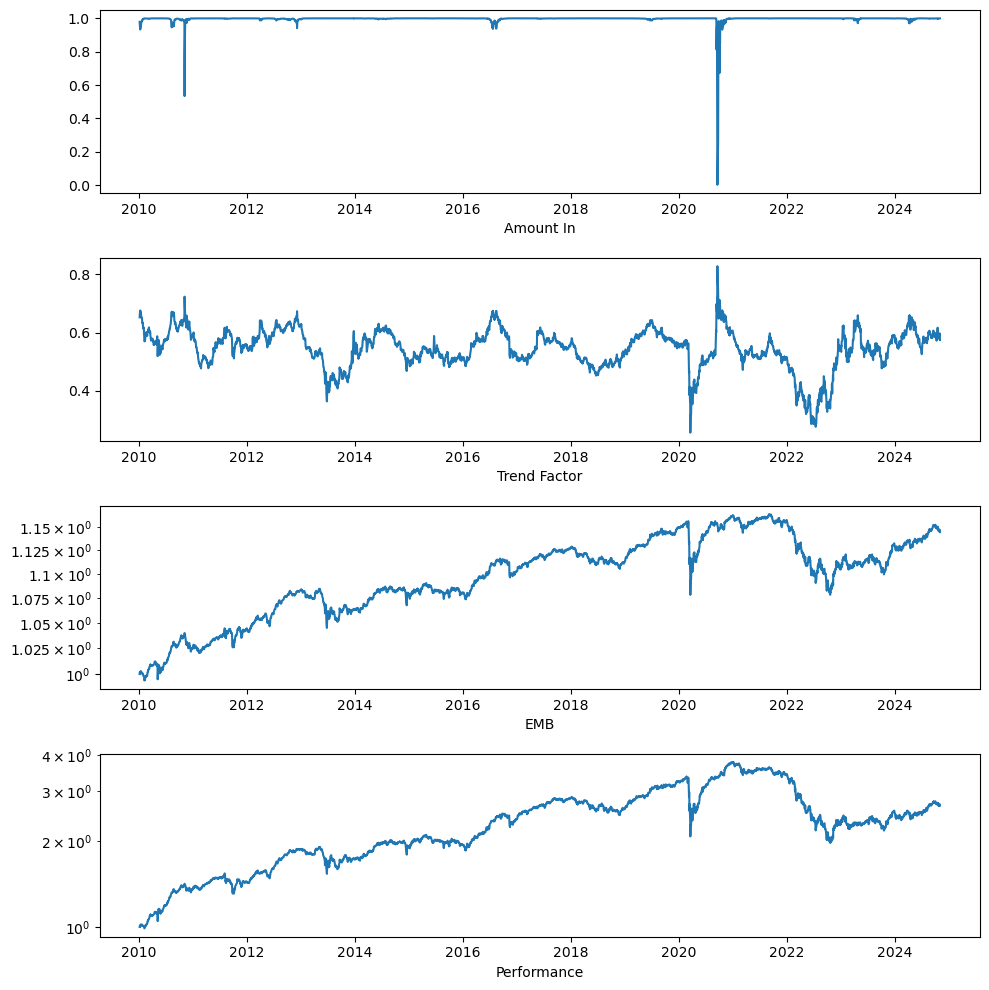

In [27]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('EMB')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [28]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('EMB')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

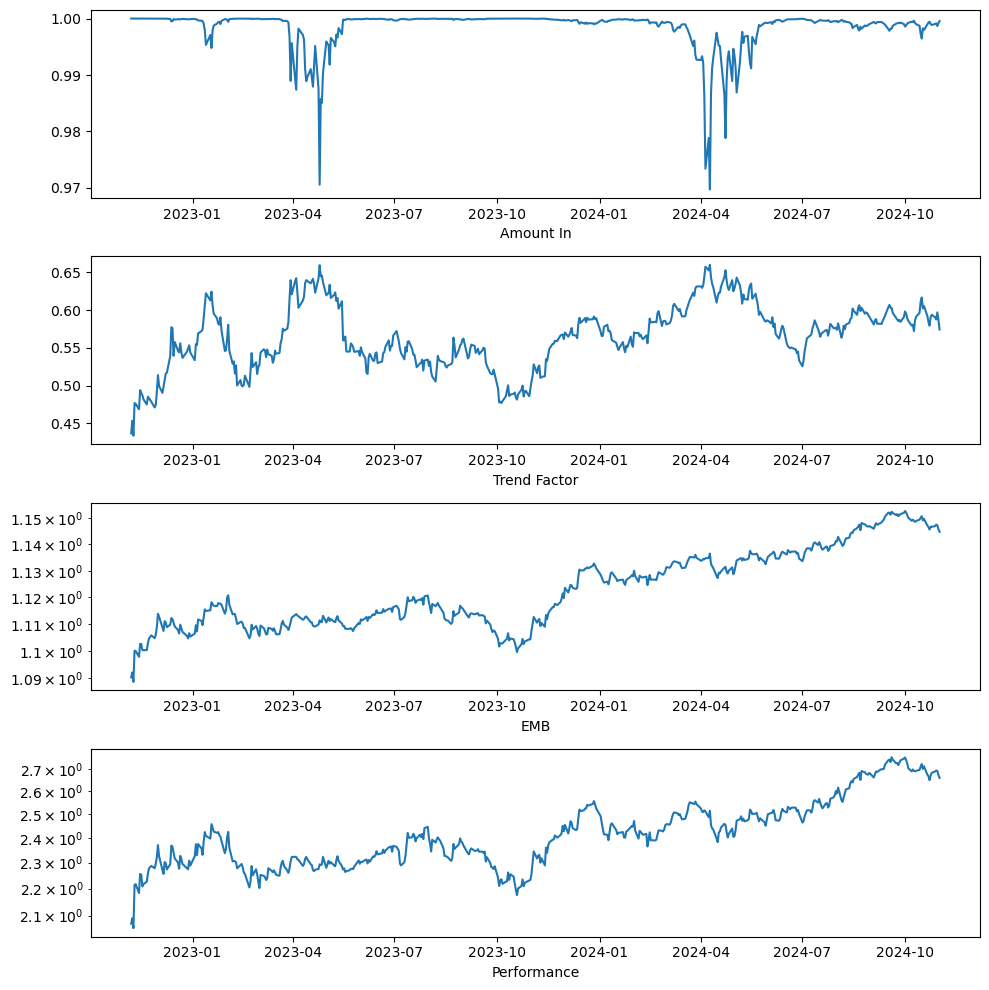

In [29]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('EMB')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [30]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.9996

In [31]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(51.00407028198242, 14.936, 90.13999938964844)

In [32]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.0676797655679815

In [33]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['emb'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1195809596024326, 1.0], 'nas': [1.2400991798626717, 1.0], 'rus': [1.289635015313776, 1.0], 'jpxn': [1.0738414738575615, 0.9804], 'ktec': [1.6302079070835445, 0.0], 'emb': [1.0676797655679815, 0.9996], 'gdx': [1.3583771630868045, 0.1098], 'dia': [1.2135937638282468, 1.0], 'nfty': [1.2330869591330673, 1.0]}


In [34]:
stop

NameError: name 'stop' is not defined

In [35]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(2.6594691536673967,
 {'time_param': 128,
  'method': 'linear',
  't': 0.7258216679560952,
  'k': 9.208825565525784,
  'as_q': False,
  'transform_f': 'bounded_sigmoid'})